<a href="https://colab.research.google.com/github/Tkaheva/MO/blob/main/jun_ml_extra_tech_boost_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boosting

На примерах урока мы увидели, что алгоритм XGBoost работает лучше и быстрее относительно GradientBoosting и AdaBoost. Поэтому в этом домашнем задании предлагаем посмотреть, какие еще интересные методы существуют в библиотеке для реализацией этого алгоритма.

### Важность признаков

Признаки, которые используют для обучения модели, оказывают большое влияние на ее качество. Неинформативные или слабо информативные признаки могут существенно понизить эффективность модели.

Отбор признаков – процесс выбора признаков, имеющих наиболее тесные взаимосвязи с целевой переменной. Он позволяет:
- уменьшить переобучение: чем меньше избыточных данных, тем меньше возможностей для модели принимать решения на основе «шума»
- повысить точность: чем меньше противоречивых данных, тем выше точность
- сократить время обучения: чем меньше данных, тем быстрее обучается модель

В библиотеке sckit-learn есть раздел feature_selection, который помогает автоматизировать этот процесс на основе методов статистики, линейной алгебры и некоторых специальных алгоритмов, таких как уже знакомый нам PCA - метод главных компонент.

Некоторые из таких методов реализованы в библиотеках для конкретных алгоритмов, к которым относится и xgboost.

Сгенерируем синтетические данные.

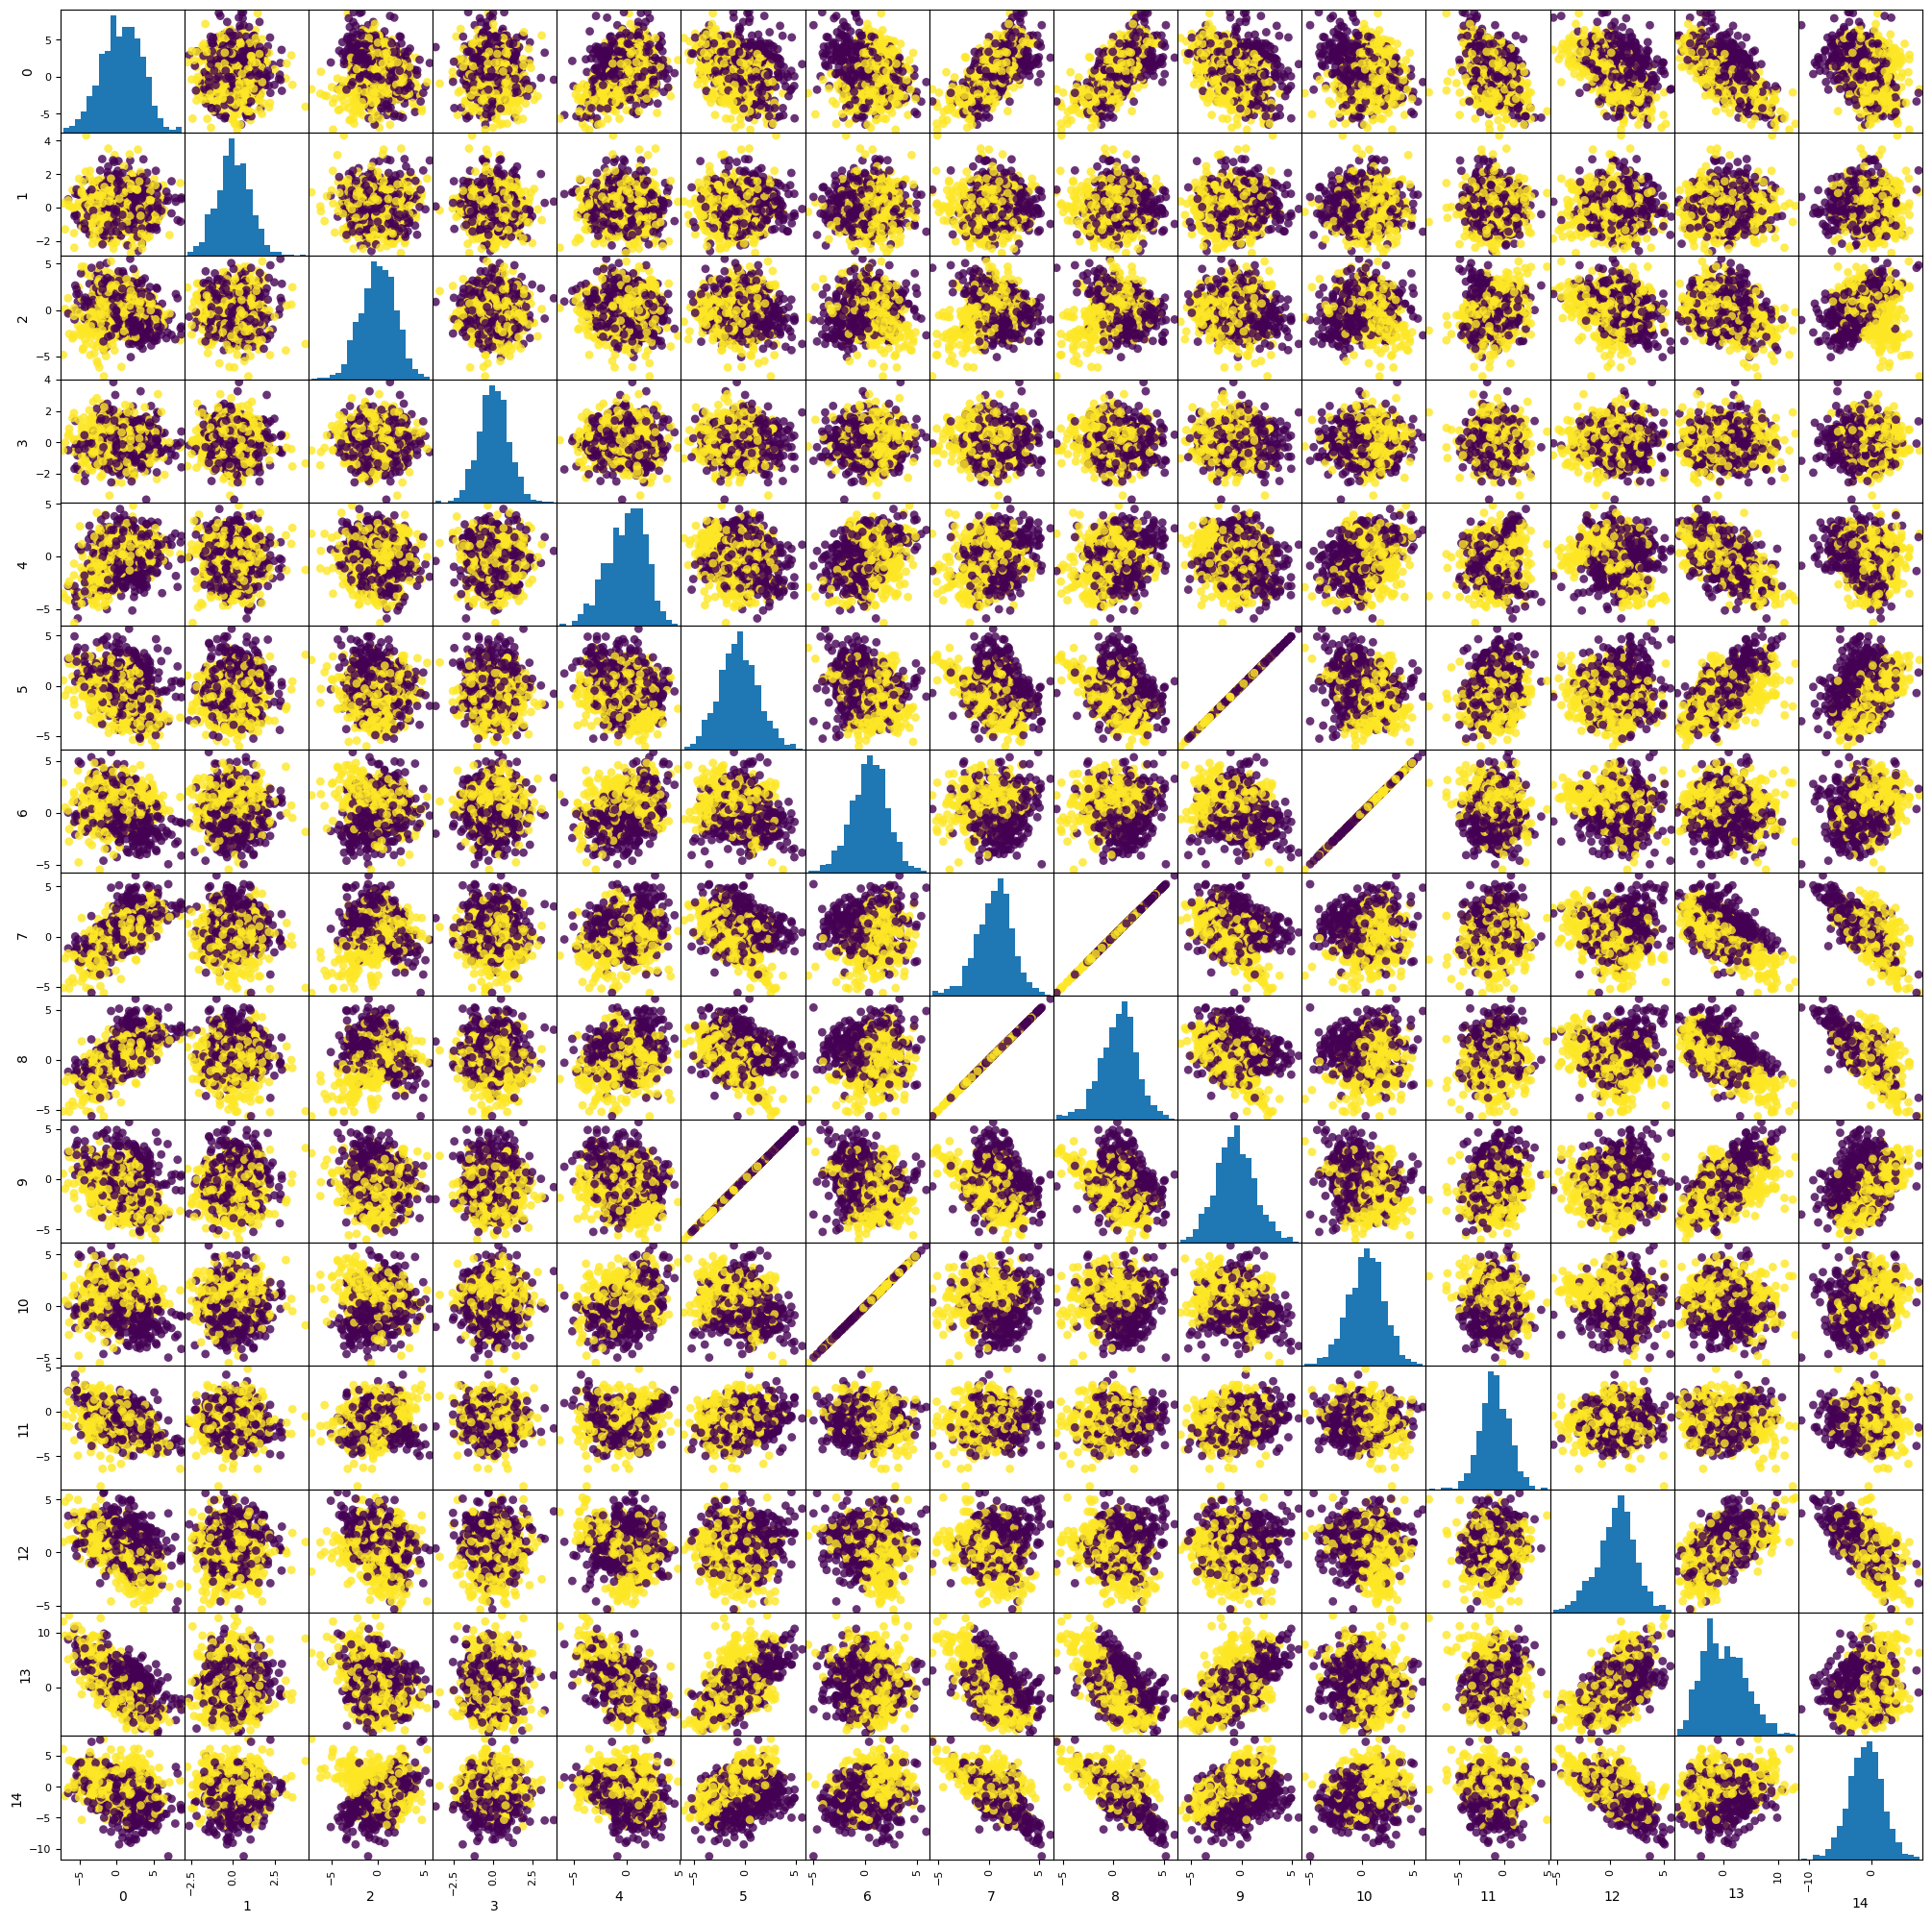

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import pandas as pd

x, y = make_classification(n_samples=1000, n_features=15, n_informative=7,
                           n_redundant=3, n_repeated=3, random_state=17)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, stratify=y, random_state=17)

features = pd.DataFrame(x)
targets = pd.Series(y)

scat_mtrx = pd.plotting.scatter_matrix(features, c=targets, figsize=(25, 25), marker='o',
                                       hist_kwds={'bins': 20}, s=40, alpha=.8)

Теперь приступим к построению модели. В уроке мы разбирали алгоритм xgboost в интерфейсе библиотеки sklearn: для обучения использовали метод *fit* модели, а для предсказаний - *predict*.

Здесь будем использовать интерфейс библиотеки xgboost.

В этом интерфейсе для обучения XGBoost данные должны быть представлены в виде объекта DMatrix - внутренней структуры данных, используемой библиотекой  XGBoost, которая оптимизирована как по эффективности работы с памятью, так и по скорости обучения.

Также заранее определим параметры алгоритма:
- бинарная классификация - 'objective': 'binary:logistic'
- глубина деревьев - 'max_depth': 3
- шаг градиентного спуска (скорость обучения) - 'eta': 0.1
- количество итераций бустинга - num_rounds = 60

In [3]:
import xgboost as xgb

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

params = {'objective': 'binary:logistic',
          'max_depth': 3,
          'eta': 0.1}

num_rounds = 60

### 1.
С помощью метода *train* библиотеки xgboost обучите модель. Передайте в метод вышеопределенные словарь параметров, тренировочные данные в формате DMatrix и число итераций.

In [5]:
print("="*60)
print("1. Обучение модели XGBoost")
print("="*60)

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

params = {'objective': 'binary:logistic',
          'max_depth': 3,
          'eta': 0.1}

num_rounds = 60

xgb_model = xgb.train(params, dtrain, num_rounds)

# Предсказания на тестовой выборке
y_pred_proba = xgb_model.predict(dtest)
y_pred = (y_pred_proba > 0.5).astype(int)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")


1. Обучение модели XGBoost
Accuracy: 0.8333
Precision: 0.8205
Recall: 0.8533


### 2.
В методе *train* есть параметр *evals* - список валидационных наборов данных, для которых будут оцениваться показатели во время обучения. Они помогут нам отслеживать качество модели для каждой итерации.

Создайте список из двух кортежей (dtest, 'test') и (dtrain, 'train'). Снова определите метод train аналогично предыдущему пункту, добавив этот список в качестве параметра.

In [6]:
print("\n" + "="*60)
print("2. Обучение с отслежижением качества")
print("="*60)

evals = [(dtest, 'test'), (dtrain, 'train')]
xgb_model = xgb.train(params, dtrain, num_rounds, evals=evals, verbose_eval=10)


2. Обучение с отслежижением качества
[0]	test-logloss:0.66218	train-logloss:0.65393
[10]	test-logloss:0.51390	train-logloss:0.44352
[20]	test-logloss:0.45077	train-logloss:0.35970
[30]	test-logloss:0.42125	train-logloss:0.31645
[40]	test-logloss:0.40732	train-logloss:0.28793
[50]	test-logloss:0.39699	train-logloss:0.26280
[59]	test-logloss:0.38914	train-logloss:0.24518


### 3.
В качестве метрики оценки важности признаков в XGBoost используется F-score, которая вычисляется на основе того, как часто делалось разбиение по данному признаку.

Используйте метод plot_importance библиотеки XGBoost. Передайте туда в качестве параметра xgb_model.


3. Важность признаков


<Figure size 1000x600 with 0 Axes>

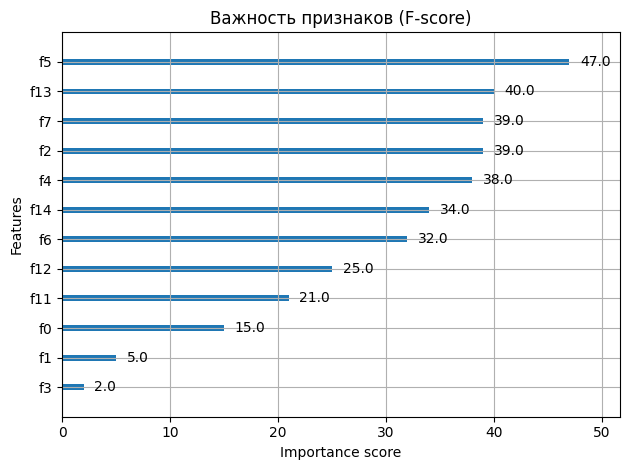

In [7]:
print("\n" + "="*60)
print("3. Важность признаков")
print("="*60)

# Метод 1: plot_importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, max_num_features=15)
plt.title('Важность признаков (F-score)')
plt.tight_layout()
plt.show()

In [8]:
# Метод 2: Получение важности признаков в виде DataFrame
importance_dict = xgb_model.get_score(importance_type='weight')
print("Важность признаков (F-score):")
for feature, importance in sorted(importance_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"  Признак {feature}: {importance}")


Важность признаков (F-score):
  Признак f5: 47.0
  Признак f13: 40.0
  Признак f2: 39.0
  Признак f7: 39.0
  Признак f4: 38.0
  Признак f14: 34.0
  Признак f6: 32.0
  Признак f12: 25.0
  Признак f11: 21.0
  Признак f0: 15.0
  Признак f1: 5.0
  Признак f3: 2.0


In [9]:
# Метод 3: Использование разных типов важности
print("\nВажность признаков по разным метрикам:")
for importance_type in ['weight', 'gain', 'cover', 'total_gain', 'total_cover']:
    try:
        importance_dict = xgb_model.get_score(importance_type=importance_type)
        if importance_dict:
            print(f"\n{importance_type}:")
            for feature, importance in sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:5]:
                print(f"  Признак {feature}: {importance:.4f}")
    except:
        pass


Важность признаков по разным метрикам:

weight:
  Признак f5: 47.0000
  Признак f13: 40.0000
  Признак f2: 39.0000
  Признак f7: 39.0000
  Признак f4: 38.0000

gain:
  Признак f14: 15.6326
  Признак f2: 12.6596
  Признак f7: 11.9982
  Признак f6: 11.7374
  Признак f5: 9.1510

cover:
  Признак f1: 100.8111
  Признак f12: 97.4977
  Признак f14: 88.6792
  Признак f13: 72.0750
  Признак f0: 65.4255

total_gain:
  Признак f14: 531.5094
  Признак f2: 493.7243
  Признак f7: 467.9314
  Признак f5: 430.0969
  Признак f6: 375.5982

total_cover:
  Признак f14: 3015.0925
  Признак f5: 2901.4180
  Признак f13: 2882.9990
  Признак f12: 2437.4434
  Признак f2: 2185.5837


По полученным данным можно посмотреть, какие признаки являются излишними и их можно убрать, а какие наиболее важны при обучении модели, т.е. используются чаще всего.

### Несбалансированные выборки

Мы уже упоминали о том, что работа с несбалансированными выборками несколько отличается от работы с идеальными датасетами. В XGBoost есть возможность несколько упростить эту работу:
- задать большие веса некоторым объектам при инициализации DMatrix
- контролировать соотношение числа объектов разных классов с помощью параметра set_pos_weight

Сгенерируем несбалансированную выборку.

In [ ]:
x, y = make_classification(n_samples=1000, n_features=7, n_informative=3, n_redundant=3,
                           n_classes=2, weights=[.9, .1], random_state=20)

print(f'There are {sum(y)} positive instances')

There are 104 positive instances


### 4.
Разбейте выборку на тренировочную и тестовую, соблюдая стратификацию по *y* и размер тестового датасета 0.3. Создайте объекты DMatrix для тренировочной и тестовой выборок.

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
print("\n" + "="*60)
print("4. Работа с несбалансированными выборками")
print("="*60)

# Генерация несбалансированной выборки
x, y = make_classification(n_samples=1000, n_features=7, n_informative=3, n_redundant=3,
                           n_classes=2, weights=[.9, .1], random_state=20)

print(f'Всего позитивных случаев (класс 1): {sum(y)}')
print(f'Всего негативных случаев (класс 0): {len(y) - sum(y)}')
print(f'Соотношение классов: {sum(y)/len(y):.3f}')

# Разделение на тренировочную и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, stratify=y, random_state=17
)

# Создание объектов DMatrix
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

print(f"\nРазмер тренировочной выборки: {x_train.shape}")
print(f"Размер тестовой выборки: {x_test.shape}")


4. Работа с несбалансированными выборками
Всего позитивных случаев (класс 1): 104
Всего негативных случаев (класс 0): 896
Соотношение классов: 0.104

Размер тренировочной выборки: (700, 7)
Размер тестовой выборки: (300, 7)


Зададим параметры для алгоритма и количество итераций.

In [ ]:
params = {'objective': 'binary:logistic',
          'max_depth': 1,
          'silent': 1,
          'eta': 1}

num_rounds = 30

### 5.
С помощью метода train обучите модель. С помощью метода predict получите предсказания для тестовых данных. Так как алгоритм возвращает вероятности, получите бинарную матрицу значений этих вероятностей, элементы которой при полученной вероятности > 0.5 равны True, а при вероятности <= 0.5 равны False. Выведите эту матрицу.

In [12]:
print("\n" + "="*60)
print("5. Обучение без учета несбалансированности")
print("="*60)

params = {'objective': 'binary:logistic',
          'max_depth': 1,
          'silent': 1,
          'eta': 1}

num_rounds = 30

xgb_model = xgb.train(params, dtrain, num_rounds)

# Получение предсказаний
y_pred_proba = xgb_model.predict(dtest)
y_pred = (y_pred_proba > 0.5).astype(bool)
print("Бинарная матрица предсказаний (первые 20 значений):")
print(y_pred[:20])
print(f"Количество предсказанных позитивных случаев: {sum(y_pred)}")



5. Обучение без учета несбалансированности
Бинарная матрица предсказаний (первые 20 значений):
[False False False False False  True False False False False False False
 False False False False False False False False]
Количество предсказанных позитивных случаев: 21


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:48:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### 6.
Выведите матрицу ошибок, точность и полноту для полученных предсказаний.

In [13]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score


6. Оценка качества без учета несбалансированности
Матрица ошибок:
[[263   6]
 [ 16  15]]
Accuracy: 0.9267
Precision: 0.7143
Recall: 0.4839


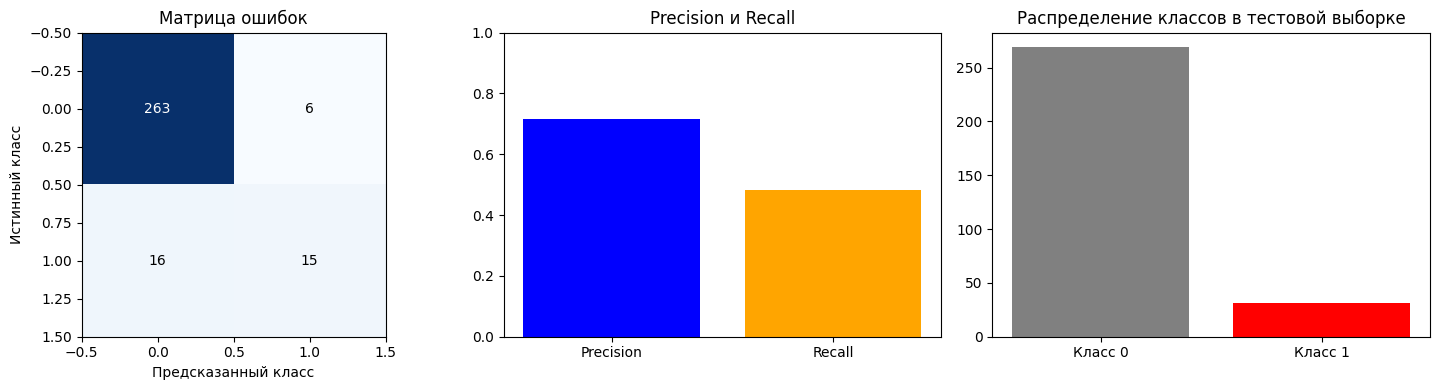

In [14]:
print("\n" + "="*60)
print("6. Оценка качества без учета несбалансированности")
print("="*60)

cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Матрица ошибок:\n{cm}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Визуализация матрицы ошибок
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Матрица ошибок
axes[0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
axes[0].set_title('Матрица ошибок')
axes[0].set_xlabel('Предсказанный класс')
axes[0].set_ylabel('Истинный класс')
for i in range(2):
    for j in range(2):
        axes[0].text(j, i, str(cm[i, j]), ha='center', va='center',
                    color='white' if cm[i, j] > cm.max()/2 else 'black')

# Precision-Recall
axes[1].bar(['Precision', 'Recall'], [precision, recall], color=['blue', 'orange'])
axes[1].set_title('Precision и Recall')
axes[1].set_ylim([0, 1])

# Распределение классов
axes[2].bar(['Класс 0', 'Класс 1'], [len(y_test) - sum(y_test), sum(y_test)],
            color=['gray', 'red'])
axes[2].set_title('Распределение классов в тестовой выборке')

plt.tight_layout()
plt.show()


Видно, что полнота гораздо ниже точности, т.е. алгоритм плохо распознает объекты класса, который представлен меньшим количеством экземпляров.

Теперь зададим вручную веса для экземпляров классов.

In [15]:
import numpy as np

weights = np.zeros(len(y_train))
weights[y_train == 0] = 1
weights[y_train == 1] = 5

### 7.
Повторите то же, что делали ранее: создайте объекты DMatrix - для тренировочных данных укажите веса, а для тестовых оставьте только сами данные; обучите модель и получите ее предсказания так же, как и в предыдущем случае. Выведите матрицу ошибок, точность и полноту.

In [16]:
print("\n" + "="*60)
print("7. Использование весов объектов")
print("="*60)

# Задание весов вручную
weights = np.zeros(len(y_train))
weights[y_train == 0] = 1
weights[y_train == 1] = 5

# Создание DMatrix с весами
dtrain_weighted = xgb.DMatrix(x_train, y_train, weight=weights)
dtest_unweighted = xgb.DMatrix(x_test, y_test)

# Обучение модели с весами
xgb_model_weighted = xgb.train(params, dtrain_weighted, num_rounds)

# Предсказания
y_pred_proba_weighted = xgb_model_weighted.predict(dtest_unweighted)
y_pred_weighted = (y_pred_proba_weighted > 0.5).astype(bool)

# Оценка качества
cm_weighted = confusion_matrix(y_test, y_pred_weighted)
accuracy_weighted = accuracy_score(y_test, y_pred_weighted)
precision_weighted = precision_score(y_test, y_pred_weighted)
recall_weighted = recall_score(y_test, y_pred_weighted)

print(f"Матрица ошибок (с весами):\n{cm_weighted}")
print(f"Accuracy: {accuracy_weighted:.4f}")
print(f"Precision: {precision_weighted:.4f}")
print(f"Recall: {recall_weighted:.4f}")

print(f"\nСравнение с моделью без весов:")
print(f"Recall улучшился на: {recall_weighted - recall:.4f}")
print(f"Precision ухудшился на: {precision_weighted - precision:.4f}")



7. Использование весов объектов


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:49:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Матрица ошибок (с весами):
[[252  17]
 [  8  23]]
Accuracy: 0.9167
Precision: 0.5750
Recall: 0.7419

Сравнение с моделью без весов:
Recall улучшился на: 0.2581
Precision ухудшился на: -0.1393


Можем увидеть, что значение полноты увеличилось, но при этом точность уменьшилась. Если нам важны обе метрики, то пригодится параметр scale_pos_weight в XGBoost.

### 8.
Снова создайте объекты DMatrix, как в первом случае (без задания весов).

In [17]:
print("\n" + "="*60)
print("8-10. Использование scale_pos_weight")
print("="*60)

# Создание DMatrix без весов
dtrain_original = xgb.DMatrix(x_train, y_train)
dtest_original = xgb.DMatrix(x_test, y_test)


8-10. Использование scale_pos_weight


### 9.
Инициализируйте параметр scale_pos_weight как соотношение числа объектов двух классов. Для этого число объектов класса 0 разделите на число объектов класса 1. Добавьте в словарь параметров алгоритма params пару с ключом 'scale_pos_weight' и значением, равным полученному соотношению классов.

In [18]:
scale_pos_weight_value = sum(y_train == 0) / sum(y_train == 1)
print(f"Соотношение классов (0/1): {scale_pos_weight_value:.2f}")

params_balanced = params.copy()
params_balanced['scale_pos_weight'] = scale_pos_weight_value
print(f"Параметры с scale_pos_weight: {params_balanced}")

Соотношение классов (0/1): 8.59
Параметры с scale_pos_weight: {'objective': 'binary:logistic', 'max_depth': 1, 'silent': 1, 'eta': 1, 'scale_pos_weight': np.float64(8.58904109589041)}


### 10.
Обучите модель с параметрами params и получите ее предсказания для тестовой выборки. Выведите матрицу ошибок, точность и полноту.**

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:51:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Матрица ошибок (с scale_pos_weight):
[[240  29]
 [  6  25]]
Accuracy: 0.8833
Precision: 0.4630
Recall: 0.8065

Сравнение всех подходов к обработке несбалансированных данных
             Метод  Accuracy  Precision   Recall  F1-score
     Без коррекции  0.926667   0.714286 0.483871  0.576923
 С весами объектов  0.916667   0.575000 0.741935  0.647887
С scale_pos_weight  0.883333   0.462963 0.806452  0.588235


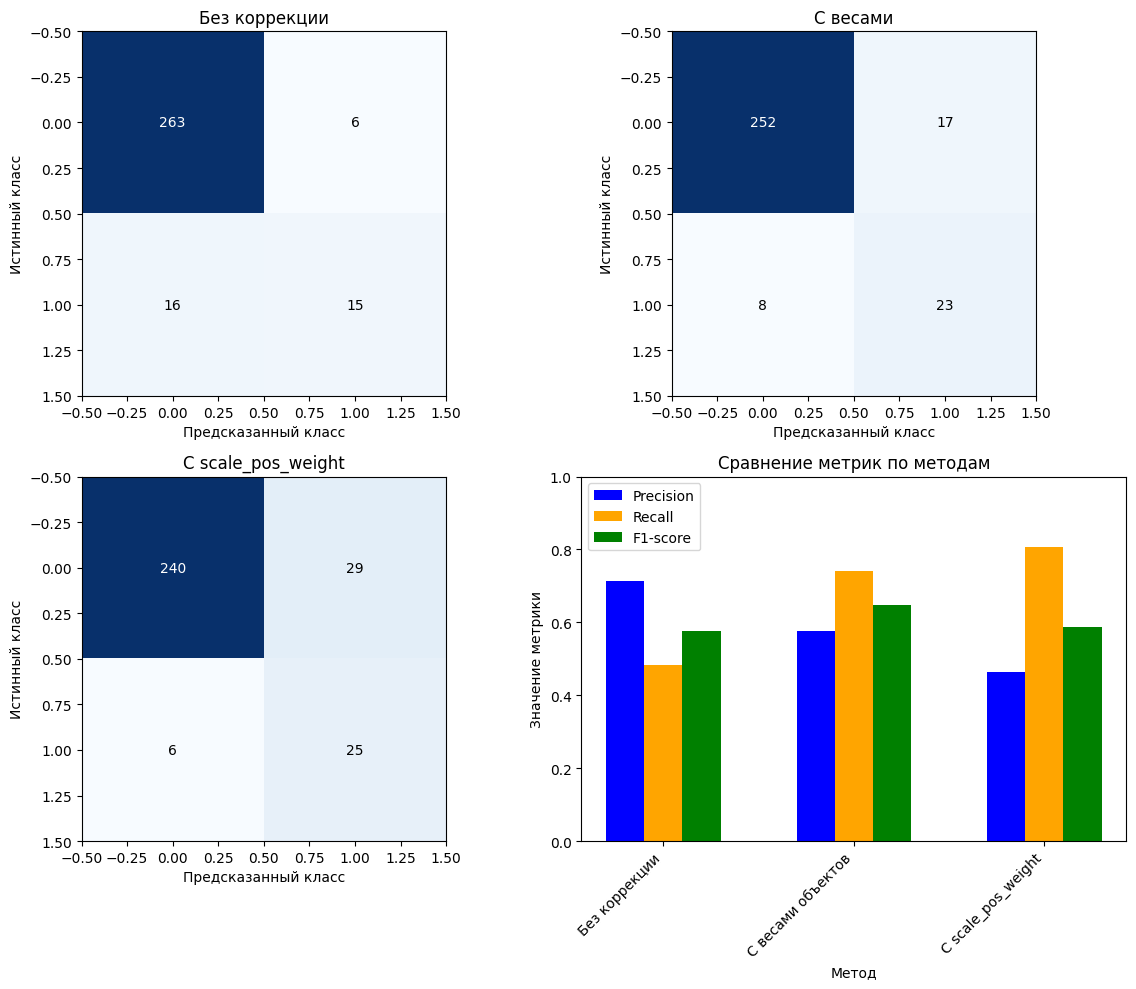


Эксперимент с разными значениями scale_pos_weight


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:51:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


scale_pos_weight = 1.00: Precision = 0.7143, Recall = 0.4839, F1 = 0.5769
scale_pos_weight = 4.29: Precision = 0.5854, Recall = 0.7742, F1 = 0.6667
scale_pos_weight = 8.59: Precision = 0.4630, Recall = 0.8065, F1 = 0.5882
scale_pos_weight = 17.18: Precision = 0.3768, Recall = 0.8387, F1 = 0.5200


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:51:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:51:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:51:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


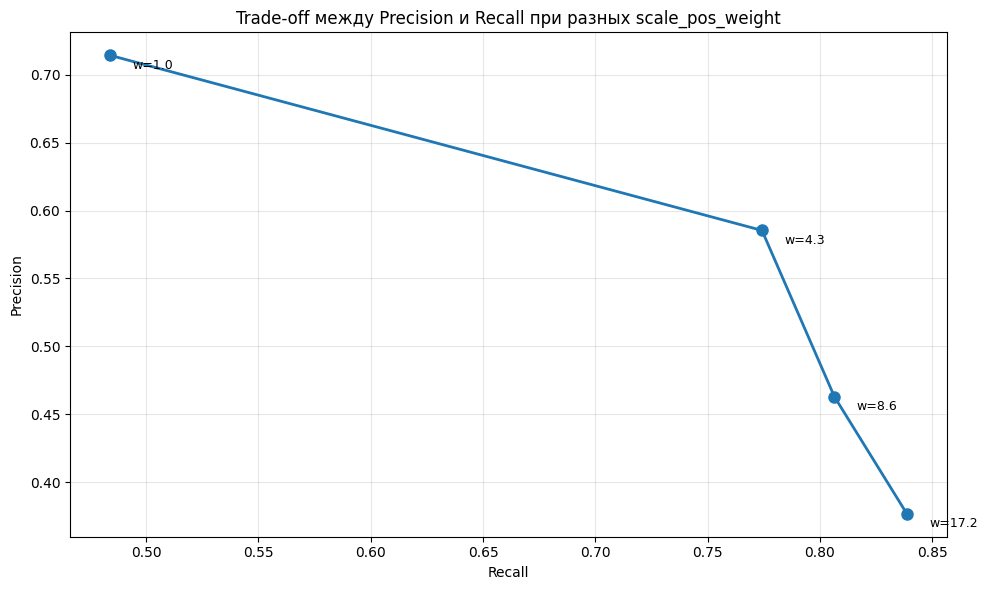


Выводы:
1. XGBoost позволяет оценивать важность признаков через F-score
2. Для несбалансированных данных можно использовать:
   - Веса объектов (weight параметр в DMatrix)
   - scale_pos_weight параметр в обучении модели
3. scale_pos_weight позволяет контролировать баланс между precision и recall
4. Оптимальное значение scale_pos_weight зависит от задачи и требуемого баланса метрик


In [19]:
xgb_model_balanced = xgb.train(params_balanced, dtrain_original, num_rounds)

# Предсказания
y_pred_proba_balanced = xgb_model_balanced.predict(dtest_original)
y_pred_balanced = (y_pred_proba_balanced > 0.5).astype(bool)

# Оценка качества
cm_balanced = confusion_matrix(y_test, y_pred_balanced)
accuracy_balanced = accuracy_score(y_test, y_pred_balanced)
precision_balanced = precision_score(y_test, y_pred_balanced)
recall_balanced = recall_score(y_test, y_pred_balanced)

print(f"\nМатрица ошибок (с scale_pos_weight):\n{cm_balanced}")
print(f"Accuracy: {accuracy_balanced:.4f}")
print(f"Precision: {precision_balanced:.4f}")
print(f"Recall: {recall_balanced:.4f}")

# Сравнение всех подходов
print("\n" + "="*60)
print("Сравнение всех подходов к обработке несбалансированных данных")
print("="*60)

comparison = pd.DataFrame({
    'Метод': ['Без коррекции', 'С весами объектов', 'С scale_pos_weight'],
    'Accuracy': [accuracy, accuracy_weighted, accuracy_balanced],
    'Precision': [precision, precision_weighted, precision_balanced],
    'Recall': [recall, recall_weighted, recall_balanced],
    'F1-score': [
        2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0,
        2 * precision_weighted * recall_weighted / (precision_weighted + recall_weighted) if (precision_weighted + recall_weighted) > 0 else 0,
        2 * precision_balanced * recall_balanced / (precision_balanced + recall_balanced) if (precision_balanced + recall_balanced) > 0 else 0
    ]
})

print(comparison.to_string(index=False))

# Визуализация сравнения
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Тепловая карта матриц ошибок
methods = [('Без коррекции', cm), ('С весами', cm_weighted), ('С scale_pos_weight', cm_balanced)]
titles = ['Без коррекции', 'С весами объектов', 'С scale_pos_weight']

for idx, (title, matrix) in enumerate(methods):
    ax = axes[idx // 2, idx % 2]
    im = ax.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(title)
    ax.set_xlabel('Предсказанный класс')
    ax.set_ylabel('Истинный класс')
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(matrix[i, j]), ha='center', va='center',
                   color='white' if matrix[i, j] > matrix.max()/2 else 'black')

# Сравнение метрик
ax = axes[1, 1]
x = np.arange(len(comparison))
width = 0.2

ax.bar(x - width, comparison['Precision'], width, label='Precision', color='blue')
ax.bar(x, comparison['Recall'], width, label='Recall', color='orange')
ax.bar(x + width, comparison['F1-score'], width, label='F1-score', color='green')

ax.set_xlabel('Метод')
ax.set_ylabel('Значение метрики')
ax.set_title('Сравнение метрик по методам')
ax.set_xticks(x)
ax.set_xticklabels(comparison['Метод'], rotation=45, ha='right')
ax.legend()
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Дополнительно: эксперимент с разными значениями scale_pos_weight
print("\n" + "="*60)
print("Эксперимент с разными значениями scale_pos_weight")
print("="*60)

scale_values = [1, scale_pos_weight_value/2, scale_pos_weight_value, scale_pos_weight_value*2]
results = []

for scale_val in scale_values:
    params_exp = params.copy()
    params_exp['scale_pos_weight'] = scale_val

    model_exp = xgb.train(params_exp, dtrain_original, num_rounds)
    y_pred_exp = (model_exp.predict(dtest_original) > 0.5).astype(bool)

    precision_exp = precision_score(y_test, y_pred_exp)
    recall_exp = recall_score(y_test, y_pred_exp)
    f1_exp = 2 * precision_exp * recall_exp / (precision_exp + recall_exp) if (precision_exp + recall_exp) > 0 else 0

    results.append({
        'scale_pos_weight': scale_val,
        'precision': precision_exp,
        'recall': recall_exp,
        'f1': f1_exp
    })

    print(f"scale_pos_weight = {scale_val:.2f}: Precision = {precision_exp:.4f}, Recall = {recall_exp:.4f}, F1 = {f1_exp:.4f}")

# Построение кривой trade-off между precision и recall
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(results_df['recall'], results_df['precision'], 'o-', linewidth=2, markersize=8)
for idx, row in results_df.iterrows():
    plt.text(row['recall'] + 0.01, row['precision'] - 0.01, f"w={row['scale_pos_weight']:.1f}",
             fontsize=9)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Trade-off между Precision и Recall при разных scale_pos_weight')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nВыводы:")
print("1. XGBoost позволяет оценивать важность признаков через F-score")
print("2. Для несбалансированных данных можно использовать:")
print("   - Веса объектов (weight параметр в DMatrix)")
print("   - scale_pos_weight параметр в обучении модели")
print("3. scale_pos_weight позволяет контролировать баланс между precision и recall")
print("4. Оптимальное значение scale_pos_weight зависит от задачи и требуемого баланса метрик")

Значение параметра scale_pos_weight надо выбирать в зависимости от желаемого соотношения между точностью и полнотой. Например, если нам нужны примерно одинаковые значения precision и recall, в данном случае следует уменьшить полученное значение параметра в несколько раз.